In [12]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util


### Pure trotterization method
This notebook performs a resource estimation for the Trotterization of a displacement Hamiltonian on an all-qubit quantum computer. The displacement Hamiltonian is given by:

$$
H = i\left( \alpha a^\dagger - \alpha^* a \right)
$$

which generates the displacement operator:

$$
e^{-iHt} = e^{\alpha a^\dagger - \alpha^* a}
$$

We analyze different orders of Trotterization and the associated logical gate counts required.

Below, we define the displacement Hamiltonian and the initial state, which consists of all qubits initialized in $ |0\rangle $.

In [13]:
def create_annihilation_operator(n_max):
    """
    Create the annihilation operator 'b' for a Fock space with cutoff n_max.

    Parameters:
        n_max (int): The Fock cutoff.

    Returns:
        np.ndarray: The annihilation operator matrix.
    """
    b = np.zeros((n_max + 1, n_max + 1), dtype=np.complex128)
    for n in range(1, n_max + 1):
        b[n - 1, n] = np.sqrt(n)
    return b

def create_creation_operator(n_max):
    """
    Create the creation operator 'b^dagger' for a Fock space with cutoff n_max.

    Parameters:
        n_max (int): The Fock cutoff.

    Returns:
        np.ndarray: The creation operator matrix.
    """
    return create_annihilation_operator(n_max).T.conj()


def displacement_hamiltonian(n_max, alpha=1):
    """
    Creates the matrix representation of the operator i*alpha(b^dagger - b).

    Parameters:
        n_max (int): The Fock cutoff.
        alpha (complex, optional): The amount of displacement. Defaults to 1.

    Returns:
        np.ndarray: The matrix representation of i*alpha(b^dagger - b).
    """
    b = create_annihilation_operator(n_max)
    b_dag = create_creation_operator(n_max)

    hamiltonian = 1j* (alpha * b_dag - alpha.conjugate() * b)

    return hamiltonian


def define_initial_state(num_modes, n_max):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    n_qubits = num_modes * int(np.ceil(np.log2(n_max + 1)))
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[0] = 1.0

    return Statevector(initial_state_vector)

The first-order Trotter expansion is:

$$
e^{-iHt} = e^{-i\sum_{i=1}^{j} H_i t} \approx e^{-iH_1 t} e^{-iH_2 t} \dots e^{-iH_j t} + O(t^2)
$$

where the total evolution time is $ t = n \cdot dt $, with $ n $ as the number of Trotter steps and $ dt $ as the time per step. As $ n \to \infty $ or $ dt \to 0 $, this approximation becomes exact.

Below, we perform a sanity check by comparing the fidelity between the exact displacement evolution (using bosonic qiskit) and its Trotterized implementation on an all-qubit system. We use different Trotter orders for a range of real displacement parameters $ \alpha $ with fixed evolution time $ t = 1 $, a fixed bosonic cutoff, and varying numbers of Trotter steps. The Hamiltonian is expressed as a sum of Pauli strings using Qiskit's `SparsePauliOp`, and then Trottization is done using `PauliEvolutionGate`.


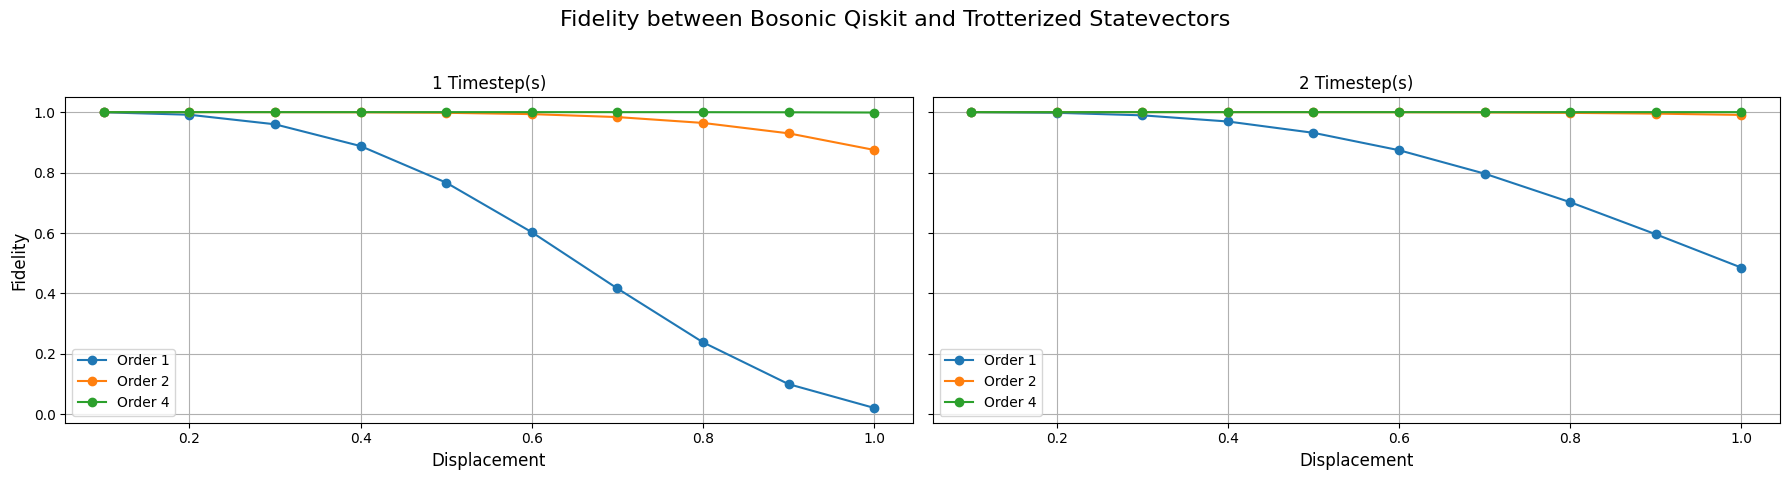

In [3]:
# =============================================================================
# Parameters and Hamiltonian Setup
# =============================================================================
num_qubits_per_mode = 3
n_max = 2**num_qubits_per_mode - 1
num_modes = 1

# Total evolution time remains fixed
evolution_time = 1.0       

# Range of alpha values for displacement
alpha_values = np.linspace(0.1, 1.0, 10)  

# Trotter orders to evaluate
trotter_orders = [1, 2, 4]

# Define different numbers of timesteps to evaluate
timestep_list = [1, 2]

# =============================================================================
# Function for Trotter Evolution with Variable Order and Timesteps
# =============================================================================
def get_trotter_circuit(H, dt, num_timesteps, initial_state, order=1):
    """
    Applies Trotter evolution to the initial_state using the specified order
    and number of timesteps, and returns the resulting circuit.
    """
    # Select synthesis method based on desired order
    if order == 1:
        synthesis_method = LieTrotter()
    elif order == 2:
        synthesis_method = SuzukiTrotter()  # Defaults to second order
    elif order == 4:
        synthesis_method = SuzukiTrotter(order=4)
    elif order == 6:
        synthesis_method = SuzukiTrotter(order=6)
    else:
        raise ValueError(f"Unsupported Trotter order: {order}. Supported orders: 1, 2, 4, 6.")
    
    trotter_gate = PauliEvolutionGate(H, dt, synthesis=synthesis_method)
    circuit = QuantumCircuit(H.num_qubits)
    
    # Initialize the circuit with the initial_state
    circuit.initialize(initial_state.data, range(H.num_qubits))
    
    # Append the Trotter evolution gate repeatedly for the number of timesteps
    for _ in range(num_timesteps):
        circuit.append(trotter_gate, range(H.num_qubits))
    
    return circuit

# =============================================================================
# Loop Over Timesteps and Alpha Values to Compute and Plot Fidelities
# =============================================================================
fig, axes = plt.subplots(1, len(timestep_list), figsize=(18, 5), sharey=True)

for idx, num_timesteps in enumerate(timestep_list):
    dt = evolution_time / num_timesteps  # Update dt for current number of timesteps
    fidelity_results = {order: [] for order in trotter_orders}

    for alpha in alpha_values:
        # Create initial state and displacement Hamiltonian
        initial_state = define_initial_state(num_modes, n_max)
        hamiltonian_matrix = displacement_hamiltonian(n_max, alpha)
        H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))

        # =============================================================================
        # Bosonic Qiskit Displacement Simulation
        # =============================================================================
        # Setup qumode registers for Bosonic Qiskit
        qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=num_qubits_per_mode)
        qumode = qmr[0]  # Convenient labeling

        # Initialize circuit (starts in |0⟩ by default)
        bosonic_circuit = c2qa.CVCircuit(qmr)

        # Apply displacement operation
        bosonic_circuit.cv_d(alpha, qumode)

        # Simulate bosonic circuit and obtain statevector
        bosonic_statevector, _, _ = c2qa.util.simulate(bosonic_circuit)

        # =============================================================================
        # Trotter Evolution and Fidelity Calculation for Each Order
        # =============================================================================
        for order in trotter_orders:
            # Compute Trotter circuit with the specified number of timesteps
            circuit = get_trotter_circuit(H, dt, num_timesteps, initial_state, order=order)

            # Compute Trotterized statevector using the selected order
            trotter_statevector = Statevector.from_instruction(circuit)

            # Compute fidelity between bosonic and Trotterized statevectors
            fidelity = state_fidelity(bosonic_statevector, trotter_statevector)

            # Store fidelity
            fidelity_results[order].append(fidelity)

    # Plot fidelity vs alpha for each Trotter order on the current subplot
    ax = axes[idx]
    for order in trotter_orders:
        ax.plot(alpha_values, fidelity_results[order], 
                marker='o', linestyle='-', label=f'Order {order}')
    ax.set_title(f'{num_timesteps} Timestep(s)')
    ax.set_xlabel('Displacement', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Fidelity', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True)

plt.suptitle('Fidelity between Bosonic Qiskit and Trotterized Statevectors', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


As expected, increasing the number of Trotter steps improves the fidelity of the evolution, and higher-order Trotterization, which reduces error, further enhances the accuracy.

Below, for each Trotter order, we calculate the number of entangling and rotation gates required as a function of the bosonic cutoff. This count is for a single Trotter step.

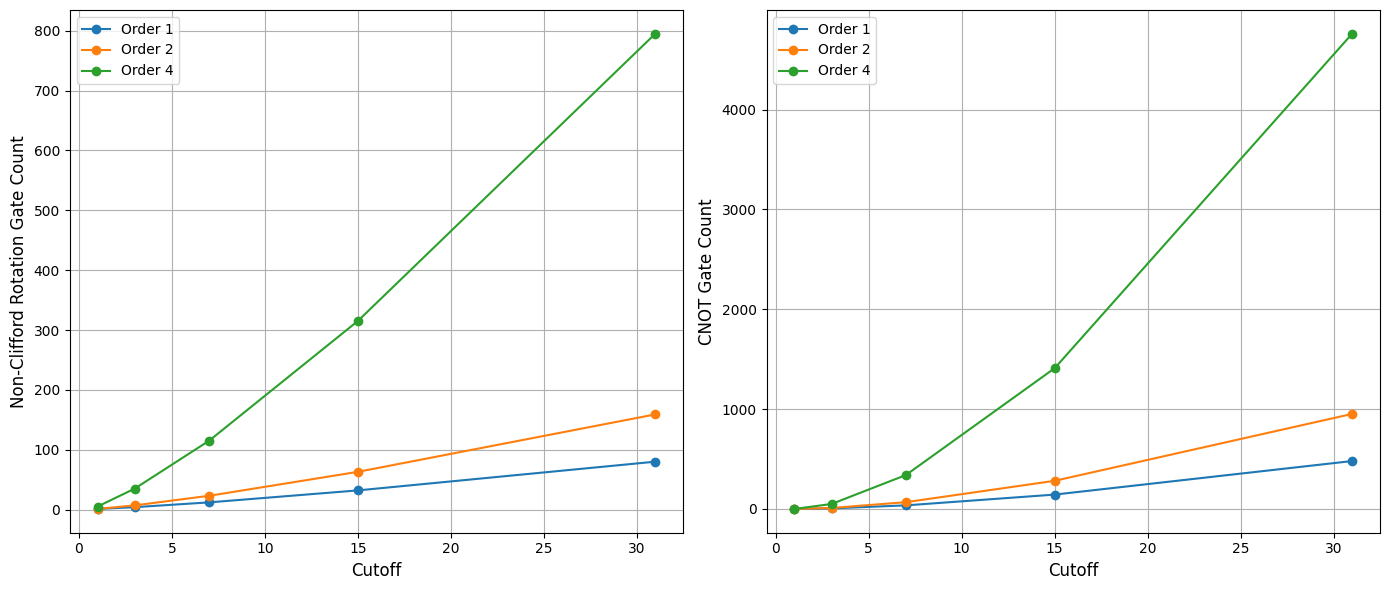

In [4]:
# =============================================================================
# Parameters for Gate Count Analysis
# =============================================================================
alpha_fixed = 0.5
evolution_time = 1
num_timesteps = 1
dt = evolution_time / num_timesteps #just a single trotter step

# Trotter orders to consider
trotter_orders = [1, 2, 4]

# Range of num_qubits_per_mode values to simulate different cutoffs
qubit_counts = range(1, 6)  
cutoff_values = [2**q - 1 for q in qubit_counts]  # Corresponding cutoffs
num_modes = 1

# Dictionaries to store results: structure {order: [values for each cutoff]}
rotation_gate_counts = {order: [] for order in trotter_orders}
cnot_gate_counts = {order: [] for order in trotter_orders}


# =============================================================================
# Loop Over Cutoff Values and Compute Gate Counts for Each Order
# =============================================================================
for cutoff in cutoff_values:
    # Create initial state and Hamiltonian for current cutoff
    initial_state = define_initial_state(num_modes, cutoff)
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))

    # Loop over each Trotter order
    for order in trotter_orders:
        # Get the decomposed Trotter circuit for the given order
        circuit = get_trotter_circuit(H, dt, num_timesteps, initial_state, order=order).decompose(reps=1)

        # Count gates
        gate_counts = circuit.count_ops()
        r_gate_count = gate_counts.get('rz', 0)  
        r_gate_count += gate_counts.get('ry', 0)
        cnot_gate_count = gate_counts.get('cx', 0)  # CNOT gate count

        # Store the counts 
        rotation_gate_counts[order].append(r_gate_count)
        cnot_gate_counts[order].append(cnot_gate_count)


# =============================================================================
# Plotting in a 1x2 grid
# =============================================================================

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Rotation Gate Count vs Cutoff
for order in trotter_orders:
    axs[0].plot(cutoff_values, rotation_gate_counts[order], marker='o', label=f'Order {order}')
axs[0].set_xlabel('Cutoff', fontsize=12)
axs[0].set_ylabel('Non-Clifford Rotation Gate Count', fontsize=12)
# axs[0].set_yscale("log")  
axs[0].legend()
axs[0].grid(True)

# CNOT Gate Count vs Cutoff
for order in trotter_orders:
    axs[1].plot(cutoff_values, cnot_gate_counts[order], marker='o', label=f'Order {order}')
axs[1].set_xlabel('Cutoff', fontsize=12)
axs[1].set_ylabel('CNOT Gate Count', fontsize=12)
# axs[1].set_yscale("log")  
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()


### CNOT Staircase Count

Using a first-order Trotterization, exponentiating a Pauli string of weight $p$ requires $2(p - 1)$ CNOT gates and one non-Clifford rotation. For a Hamiltonian

$$H = \sum_{j=1}^P p_j,$$

where each Pauli string $p_j$ has weight $r_j$, the total CNOT count is

$$\sum_{j=1}^P 2(r_j - 1),$$

and the number of non-Clifford rotations is $P$. We'll compare these counts with our Trotterized Qiskit circuit.


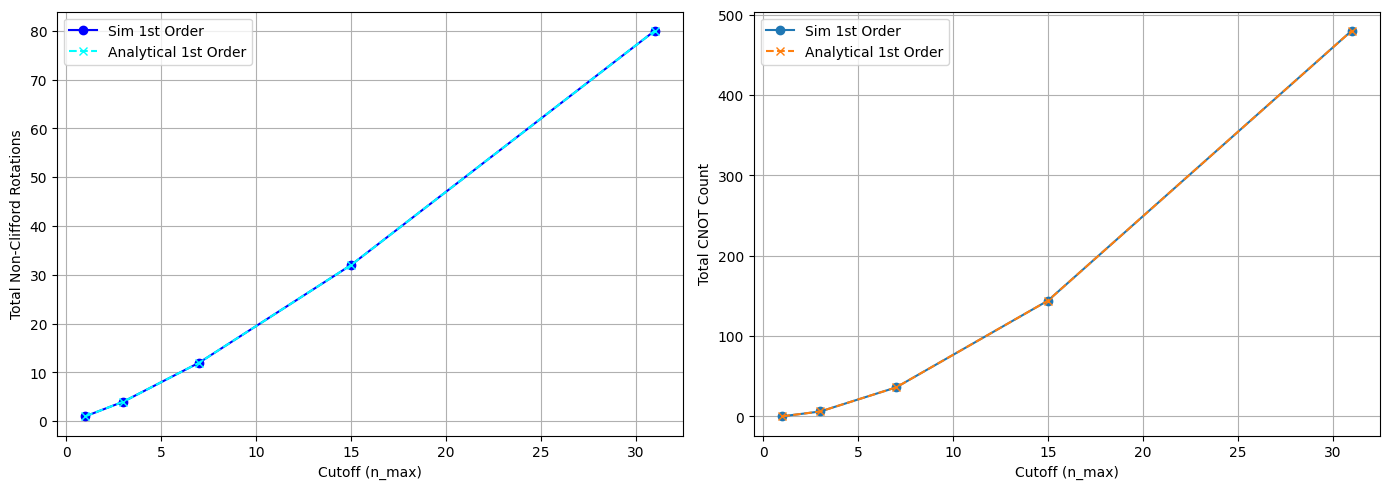

In [5]:
# =============================================================================
# Analytical Calculation for First and Second Order
# =============================================================================
analytical_cnot_counts_1 = []

analytical_nonclifford_counts_1 = []

# Range of num_qubits_per_mode values to simulate different cutoffs
for cutoff in cutoff_values:
    # Generate the Hamiltonian matrix for the current cutoff
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    
    # Convert matrix to a SparsePauliOp
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    
    # Extract terms as a list of tuples: (pauli_string, coefficient)
    terms = H.to_list()
    
    total_cnot_count_1 = 0
    
    for p_str, coeff in terms:
        # Calculate effective length ignoring 'I'
        effective_length = len(p_str.replace('I', ''))
        
        # First-order CNOT count for the current term
        total_cnot_count_1 += 2 * max(effective_length - 1, 0)
        
    
    analytical_cnot_counts_1.append(total_cnot_count_1)
    
    # Non-Clifford counts for each order
    nonclifford_count_1 = len(terms)           # first-order
    
    analytical_nonclifford_counts_1.append(nonclifford_count_1)

# =============================================================================
# Compare Simulation and Analytical Results on Combined Graphs
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Non-Clifford Rotations Comparison 
axes[0].plot(cutoff_values, rotation_gate_counts[1], marker='o', linestyle='-', 
             label='Sim 1st Order', color='blue')
axes[0].plot(cutoff_values, analytical_nonclifford_counts_1, marker='x', linestyle='--', 
             label='Analytical 1st Order', color='cyan')

axes[0].set_xlabel('Cutoff (n_max)')
axes[0].set_ylabel('Total Non-Clifford Rotations')
axes[0].legend()
axes[0].grid(True)

# CNOT Counts Comparison 
axes[1].plot(cutoff_values, cnot_gate_counts[1], marker='o', linestyle='-', 
             label='Sim 1st Order')
axes[1].plot(cutoff_values, analytical_cnot_counts_1, marker='x', linestyle='--', 
             label='Analytical 1st Order')
axes[1].set_xlabel('Cutoff (n_max)')
axes[1].set_ylabel('Total CNOT Count')
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()

We can go further and work out the number of (non-Clifford) rotations and an upper bound on the number of CNOTs in terms of the cutoff. The number of terms in the sum, and hence the number of non-Clifford rotations, is   
$$ 
N_{\text{rotations}} = q\,2^{(q-1)} = \tfrac{1}{2}\log_2(n_{\max}+1)\,(n_{\max}+1), 
$$
where $q = \log_2(n_{\max}+1)$ is the number of qubits needed (to represent the highest Fock state for cutoff $n_{max}$), and hence the maximum Pauli weight. 

The total CNOT count is then

$$
N_{\mathrm{cnots}} = \sum_{j=1}^P 2(q-1) \;=\; 2(q-1)P \;=\; 2(q-1)\,q\,2^{(q-1)},
$$

and since $2^{(q-1)} = \tfrac{1}{2}(n_{\max}+1)$, we get

$$
N_{\mathrm{cnots}} = \log_2(n_{\max}+1)\,\Bigl[\log_2(n_{\max}+1)-1\Bigr]\,(n_{\max}+1).
$$

This is an upper bound because some Pauli strings include identities (don't contribute to weight), so they require fewer CNOTs than the maximal-weight case.

Below, we plot this scaling to verify.

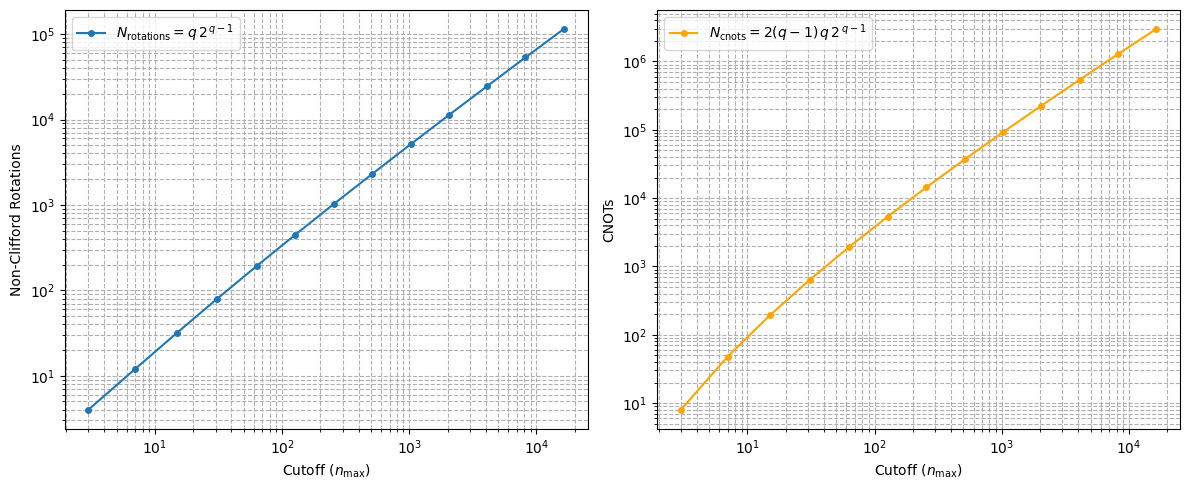

In [6]:
# Define qubit counts and corresponding cutoffs
qubit_counts = range(2, 15)  
cutoff_values = [2**q - 1 for q in qubit_counts]

# Work out rotations for each cutoff (using n_max = cutoff)
# Note: q = log2(n_max+1)
N_rotations = [0.5 * (cutoff + 1) * math.log2(cutoff + 1) for cutoff in cutoff_values]

# Compute CNOTs for each cutoff:
cnots_values = [math.log2(cutoff + 1) * (math.log2(cutoff + 1) - 1) * (cutoff + 1) for cutoff in cutoff_values]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(cutoff_values, N_rotations, marker='o', linestyle='-', markersize=4,
             label=r"$N_{\text{rotations}} = q\,2^{\,q-1}$")
axes[0].set_xlabel("Cutoff ($n_{\max}$)")
axes[0].set_ylabel("Non-Clifford Rotations")
axes[0].grid(True, which="both", ls="--")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend(loc='best') 

axes[1].plot(cutoff_values, cnots_values, marker='o', linestyle='-', markersize=4, color='orange',
             label=r"$N_{\text{cnots}} = 2(q-1)\,q\,2^{\,q-1}$")
axes[1].set_xlabel("Cutoff ($n_{\max}$)")
axes[1].set_ylabel("CNOTs")
axes[1].grid(True, which="both", ls="--")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(loc='best')  

plt.tight_layout()

# Show the plots
plt.show()


# Trotter Errors
The error for first-order Trotterization is bounded by $\mathcal{O}(c \alpha^2 t^2)$, where $\alpha$ is the displacement size ($\alpha^2$ from the commutators), and the coefficient $c$ determined by $n_{\text{max}}$. Below, we verify this bound for a fixed $n_{\text{max}}$.

In [7]:
def commutator_spectral_norm(group_A, group_B):
    # Convert group operators to dense matrix form
    A_matrix = group_A.to_matrix()
    B_matrix = group_B.to_matrix()
    
    commutator = A_matrix @ B_matrix - B_matrix @ A_matrix
    # Return the spectral norm (largest singular value) of the commutator
    return np.linalg.norm(commutator, 2)

def compute_error_sum(hamiltonian_matrix):
    """
    Given a list of commuting groups (H_groups), compute the sum of spectral
    norms of commutators over all distinct pairs of groups.
    """
    # Create SparsePauliOp from the operator and group commuting terms
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    H_groups = H.group_commuting()
    error_sum = 0.0
    num_groups = len(H_groups)
    for i in range(num_groups):
        for j in range(i + 1, num_groups):
            error_sum += commutator_spectral_norm(H_groups[i], H_groups[j])
    return error_sum

nmax_values = [3, 7]
alpha_values = [1.0, 2.0, 3.0] 

error_estimates = {}

# store coefficients for each n_max when alpha = 1.0
coeffs = {n_max: 0.0 for n_max in nmax_values}

for alpha in alpha_values:
    # dictionary for current alpha's results
    error_estimates[alpha] = {}
    for n_max in nmax_values:
        hamiltonian_matrix = displacement_hamiltonian(n_max, alpha)

        # Compute the error sum for these groups using our function
        error_sum = compute_error_sum(hamiltonian_matrix)

        # Stor
        error_estimates[alpha][n_max] = error_sum

        if alpha == 1.0:
            coeffs[n_max] = error_sum

for alpha in alpha_values:
    print(f"\nAlpha = {alpha}:")
    for n_max in nmax_values:
        error = error_estimates[alpha][n_max]
        if alpha == 1.0:
            # For alpha = 1.0, the coefficient is the error_sum itself
            print(f"  n_max = {n_max}: Error estimate ~ {error:.3g} * t^2")
        else:
            # Compute the coefficient by dividing by alpha^2
            coeff = error / (alpha ** 2)
            alpha_sq = alpha ** 2
            # 3 sig fig
            error_formatted = f"{error:.3g}"
            alpha_sq_formatted = f"{alpha_sq:.3g}"
            coeff_formatted = f"{coeff:.3g}"
            print(f"  n_max = {n_max}: Error estimate ~ {error_formatted} * t^2")
            print(f"    ≈ {alpha_sq_formatted} * {coeff_formatted} * t^2")



Alpha = 1.0:
  n_max = 3: Error estimate ~ 2.45 * t^2
  n_max = 7: Error estimate ~ 14.1 * t^2

Alpha = 2.0:
  n_max = 3: Error estimate ~ 9.8 * t^2
    ≈ 4 * 2.45 * t^2
  n_max = 7: Error estimate ~ 56.4 * t^2
    ≈ 4 * 14.1 * t^2

Alpha = 3.0:
  n_max = 3: Error estimate ~ 22 * t^2
    ≈ 9 * 2.45 * t^2
  n_max = 7: Error estimate ~ 127 * t^2
    ≈ 9 * 14.1 * t^2


## Comparing to a Noisy Cavity
Above, we have calculated the resources required for a single Trotter step of $H = i\left( \alpha a^\dagger - \alpha^* a \right)$ on all qubit hardware. This corresponds to a displacement, which is a native gate on most hybrid oscillator-qubit quantum proccessors. However, for a fair comparison, we need to take into account that these gates are noisy, and due to the [no threshold theorem](https://arxiv.org/abs/2102.05545) for continous variable quantum information, we can't make the "native" bosonic computational resources fault tolerant.

An initial first approach is to calculate the error rate (or fidelity) of the displacement operator (for some realistic photon loss noise), and calculate the *all-qubit* resources needed to achieve the same, or better error rate.

Below, we implement the displacement operator in Bosonic Qiskit under photon loss and evaluate the fidelity relative to the "ideal displaced state."

In [8]:
def simulate_mode_displacement(alpha, noise=True, photon_loss_rate=0.0001, gate_time = 100, shots=100):
    """
    Simulates a qumode initialized in Fock state |1> with a displacement gate.
    
    Args:
        alpha (float): Size of the displacement.
        noise (bool): Whether to include photon loss noise in the simulation.
        photon_loss_rate (float): Photon loss rate in units of 1/ns (only relevant if noise=True).
        shots (int): Number of shots for the simulation (only relevant if noise=True).
        
    Returns:
        Statevector: If noise=True, returns a tuple of statevectors. If noise=False, returns the statevector.
    """
    # Define the number of qumodes and qubits per qumode
    num_qumodes = 1
    num_qubits_per_qumode = 4 # Cutoff = 2^4 = 16
    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    
    # Create the circuit
    circuit = c2qa.CVCircuit(qmr)
    
    # Initialize the qumode in Fock state |1>
    circuit.cv_initialize(1, qmr[0])
    
    # Apply a displacement gate
    circuit.cv_d(alpha, qmr[0], duration=gate_time if noise else None, unit="ns" if noise else None)
    
    if noise:
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        
        # Run the simulation with noise
        state, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass
        )
        return state
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state

In [9]:
def compute_average_fidelity(alpha, photon_loss_rate=0.0001, gate_time=100, shots=100):
    """
    Computes the average fidelity between the noiseless statevector and individual noisy statevectors,
    and the error from shot noise.
    
    Args:
        alpha (float): Size of the displacement (amplitude).
        photon_loss_rate (float): Photon loss rate in units of 1/ns.
        gate_time (float): Gate time in ns.
        shots (int): Number of shots for the noisy simulation.
        
    Returns:
        tuple: The average fidelity and the shot noise error.
    """
    # Simulate the noiseless state
    state_no_noise = simulate_mode_displacement(alpha, noise=False)
    
    # Simulate the noisy statevectors
    noisy_statevectors = simulate_mode_displacement(alpha, noise=True, photon_loss_rate=photon_loss_rate, gate_time=gate_time, shots=shots)
    
    # Calculate fidelity for each noisy statevector
    fidelities = [state_fidelity(state_no_noise, noisy_state) for noisy_state in noisy_statevectors]
    
    # Compute the average fidelity
    average_fidelity = np.average(fidelities)
    
    # Calculate the standard error
    std_error = np.std(fidelities) / np.sqrt(shots)
    
    return average_fidelity, std_error

In [10]:
## Suppress specific warnings
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", message="PhotonLossNoisePass ignores instructions without duration")
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

# # Define parameters
photon_loss_rates = np.linspace(1e-4, 0.02, num=7)   # Photon loss from 10^-4 to 2x10^-2 (in 1/ns)
gate_times = [5, 20, 50]  # Gate times in ns
alpha = 1  # Fixed displacement value
shots = 2048


# Placeholder for results
results = {}

for gate_time in gate_times:
    # Initialize placeholders for fidelities and errors
    fidelities = []
    errors = []
    for photon_loss_rate in photon_loss_rates:
        average_fidelity, std_error = compute_average_fidelity(alpha, photon_loss_rate, gate_time, shots)
        fidelities.append(average_fidelity)
        errors.append(std_error)
    
    # Store both fidelities and errors for the current gate time
    results[gate_time] = {
        'fidelities': fidelities,
        'errors': errors
    }

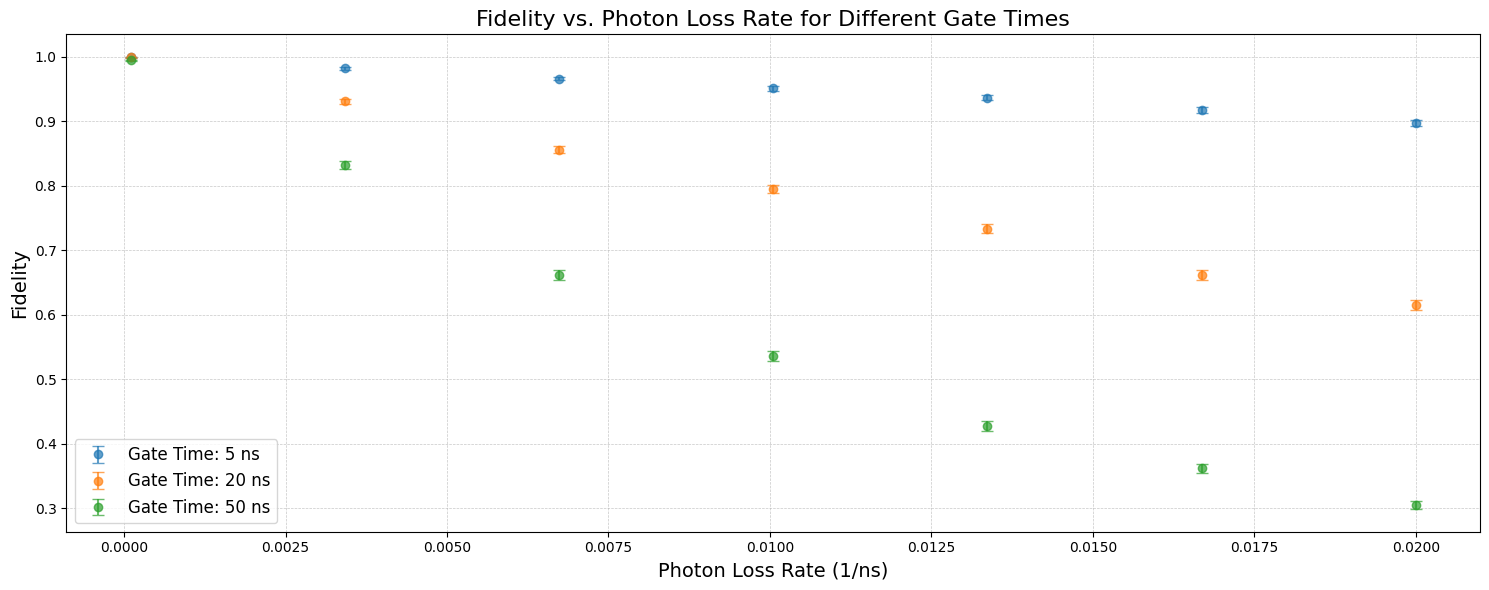

In [11]:
# Plotting the data points with error bars
plt.figure(figsize=(15, 6))

# Loop over each gate time to plot its corresponding data
for gate_time in gate_times:
    # Extract fidelities and errors for the current gate time
    fidelities = np.array(results[gate_time]['fidelities'])
    errors = np.array(results[gate_time]['errors'])
    
    # Plot the data points with error bars
    plt.errorbar(
        photon_loss_rates,
        fidelities,
        yerr=errors,
        fmt='o',               
        capsize=4,            
        label=f'Gate Time: {gate_time} ns',
        markersize=6,         
        linestyle='None',    
        alpha=0.7             
    )

# Customize the plot
plt.xlabel('Photon Loss Rate (1/ns)', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.title('Fidelity vs. Photon Loss Rate for Different Gate Times', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()